# DisSent Error Analysis

We load in pickle file from the best Books 5, and analyze the error.

Outline:
1. Basic error analysis -- compare the number of `because` examples to other discourse marker. **Conclusion**: the primary driver of `because`'s low performance is due to a very low number of `because` examples in the dataset.
2. We analyze the **perfectly balanced** dataset's performance and see if `because` is still behind.
3. Use `Deep Taylor` method to highlight the sentence on one class (`because`).

In [77]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
import torch
dis_net = torch.load(os.path.join('./exp/books5_words_4096_sgd_01_d0_fcd0', 'dis-model-11'  + ".pickle"))

In [3]:
torch.cuda.set_device(1)

In [7]:
dis_net.s1_only = False
dis_net.s2_only = False
dis_net.cuda()

DisSent(
  (encoder): BLSTMEncoder(
    (enc_lstm): LSTM(300, 4096, bidirectional=True)
    (emb_drop): Dropout(p=0.0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=40960, out_features=512)
    (1): Linear(in_features=512, out_features=512)
    (2): Linear(in_features=512, out_features=5)
  )
)

In [5]:
"""
DATA
"""
import numpy as np
from data import get_dis, get_batch, build_vocab, get_filtered_dis

train, valid, test = get_dis('/home/anie/DisExtract/data/books', 
                                      'discourse_EN_FIVE_and_but_because_if_when_2017dec12')
word_vec = build_vocab(train['s1'] + train['s2'] +
                       valid['s1'] + valid['s2'] +
                       test['s1'] + test['s2'], '/home/anie/glove/glove.840B.300d.txt')

# unknown words instead of map to <unk>, this directly takes them out
for split in ['s1', 's2']:
    for data_type in ['train', 'valid', 'test']:
        eval(data_type)[split] = np.array([['<s>'] +
                                           [word for word in sent.split() if word in word_vec] +
                                           ['</s>'] for sent in eval(data_type)[split]])

Here we present the distribution of this dataset! (The number indicates validation examples, but the ratio is similar between train/valid split)

| Books 5 | Number   | Precision | Recall   |
| ------- | -------- | --------- | -------- |
| and     | 50958    | 0.72      | 0.78     |
| because | **8468** | **0.45**  | **0.36** |
| but     | 51574    | 0.71      | 0.73     |
| if      | 23642    | 0.79      | 0.75     |
| when    | 26185    | 0.61      | 0.62     |
| while   | **8055** | **0.46**  | **0.36** |
| after   | **4886** | **0.55**  | **0.42** |
| also    | **811**  | **0.36**  | **0.14** |
| still   | **698**  | **0.42**  | **0.21** |

It is worth noting that `because` is more difficult to learn in Books5 because it is the rarest class, a good indiciation is `while` having about the same amount of examples has a similar precision and recall.

But this is not to say `because` is not more difficult, mostly because `after`, `also`, and `still` all have similar precision while having fewer examples compared to `because`.

In [71]:
from util import get_labels
dis_labels = get_labels('books_5')

In [9]:
from viz import collect_type_errors
correct, type_one, type_two, num_pred_made, num_target_marker = collect_type_errors(dis_net, valid, word_vec, dis_labels.index('because'))

In [11]:
import json
json.dump(type_one, open('./type_one_error_list.json', 'wb'))
json.dump(type_two, open('./type_two_error_list.json', 'wb'))
json.dump(correct, open('./correct_list.json', 'wb'))

In [49]:
print("Number of Type I errors: {}".format(len(type_one)))
print("Number of Type II errors: {}".format(len(type_two)))

Number of Type I errors: `2689`

Number of Type II errors: `5362`

Precision: `3105 / 5794 = 53.58%` (correct predictions / all predictions)

Recall: `3105 / 8468 = 36.67%` (correct predictions / all true markers)

From Books 5 Val dataset:

| Pred \ Label | True | False  |
| ------------------------ | ---- | ------ |
| Positive                 | 3105 | **2689**   |
| Negative                 | **5362** | 152359 |


## Visualization

Since we are unable to draw a conclusion from basic analysis of class imbalance.

WARNING: remember to build_vocab first, and pass all sentences to avoid loading glove twice.

In [18]:
import json
type_one = json.load(open('./type_one_error_list.json', 'rb'))
type_two = json.load(open('./type_two_error_list.json', 'rb'))
correct = json.load(open('./correct_list.json', 'rb'))

In [19]:
len(correct)

124221

In [33]:
from viz import CDLSTM

In [ ]:
dis_net = dis_net.cpu()

In [21]:
stacked_sent_one = [tup[0] for tup in correct + type_one + type_two]
stacked_sent_two = [tup[1] for tup in correct + type_one + type_two]
stacked_sents = stacked_sent_one + stacked_sent_two

In [63]:
cdlstm = CDLSTM(dis_net, "/home/anie/glove/glove.840B.300d.txt")

In [64]:
cdlstm.build_vocab(stacked_sents, tokenize=False, already_split=True)

In [65]:
scoresA, scoresB = cdlstm.get_word_level_scores(correct[0][0], correct[0][1])

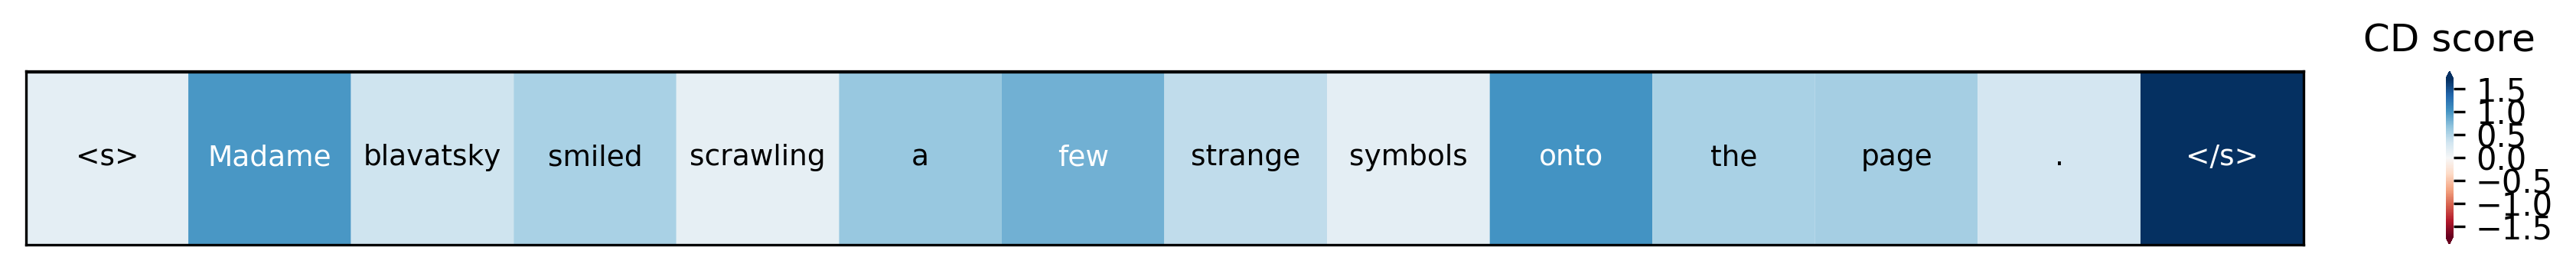

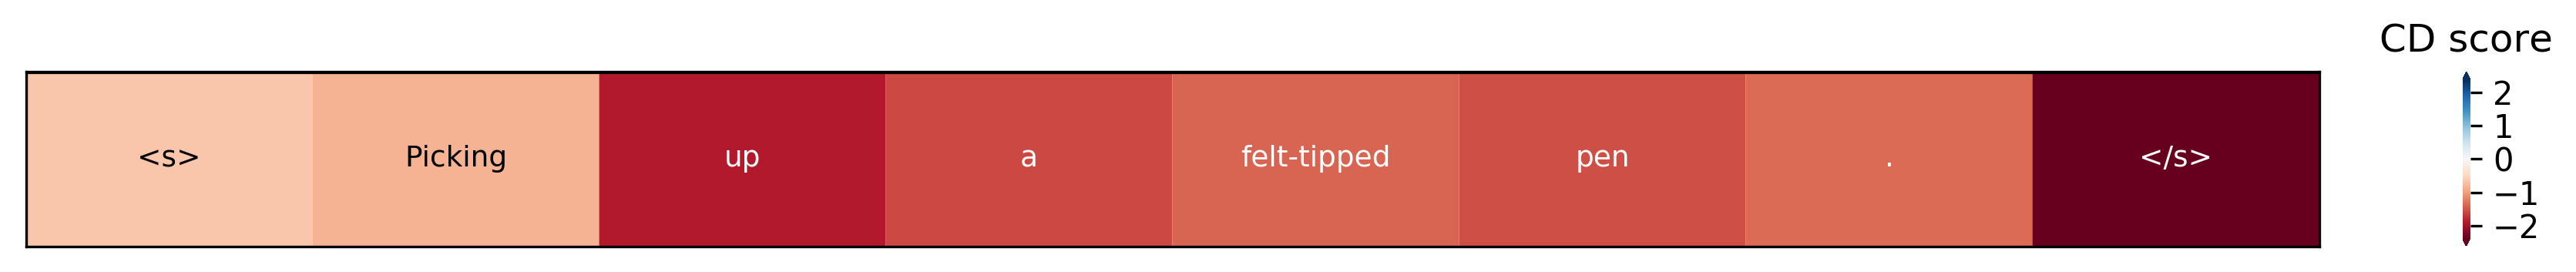

In [95]:
word_heatmap(correct[0][0], scoresA[:, 1])
word_heatmap(correct[0][1], scoresB[:, 1])

In [91]:
import matplotlib.pyplot as plt
import math
import matplotlib.colors as colors

def word_heatmap(text_orig, scores, data=None, fontsize=9):
    text_orig = np.array(text_orig)
    num_words = text_orig.size

    comps_list = [np.array(range(num_words))]
    num_iters = len(comps_list)

    scores_list = scores

    # populate data
    if data is None:
        data = np.empty(shape=(num_iters, num_words))
        data[:] = np.nan
        data[0, :] = scores_list

    data[np.isnan(data)] = 0  # np.nanmin(data) - 0.001
    if num_iters == 1:
        plt.figure(figsize=(16, 1), dpi=300)
    else:
        plt.figure(figsize=(16, 3), dpi=300)

    class MidpointNormalize(colors.Normalize):
        def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
            self.midpoint = midpoint
            colors.Normalize.__init__(self, vmin, vmax, clip)

        def __call__(self, value, clip=None):
            x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
            return np.ma.masked_array(np.interp(value, x, y))

            #     cmap = plt.get_cmap('RdBu') if label_pred == 0 else plt.get_cmap('RdBu_r')

    cmap = plt.get_cmap('RdBu')
    #if label_pred == 1:
    #    data *= -1
    # cmap = matplotlib.cm.Greys
    # cmap.set_bad(color='black')
    #                    cmap='viridis')#'RdBu')
    abs_lim = max(abs(np.nanmax(data)), abs(np.nanmin(data)))

    c = plt.pcolor(data,
                   edgecolors='k',
                   linewidths=0,
                   norm=MidpointNormalize(vmin=abs_lim * -1, midpoint=0., vmax=abs_lim),
                   cmap=cmap)

    def show_values(pc, text_orig, data, fontsize, fmt="%s", **kw):
        val_mean = np.nanmean(data)
        val_min = np.min(data)
        pc.update_scalarmappable()
        # ax = pc.get_axes()
        ax = pc.axes

        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            # pick color for text
            if np.all(color[:3] > 0.5):  # value > val_mean: #value > val_mean: #
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            x_ind = int(math.floor(x))
            y_ind = int(math.floor(y))

            # sometimes don't display text
            if y_ind == 0 or data[y_ind, x_ind] != 0:  # > val_min:
                ax.text(x, y, fmt % text_orig[x_ind],
                        ha="center", va="center",
                        color=color, fontsize=fontsize, **kw)

    show_values(c, text_orig, data, fontsize)
    cb = plt.colorbar(c, extend='both')  # fig.colorbar(pcm, ax=ax[0], extend='both')
    cb.outline.set_visible(False)
    plt.xlim((0, num_words))
    plt.ylim((0, num_iters))
    plt.yticks([])
    plt.plot([0, num_words], [1, 1], color='black')
    plt.xticks([])

    cb.ax.set_title('CD score')

In [53]:
weights = dis_net.encoder.enc_lstm.state_dict()

In [54]:
weights.keys()

['weight_ih_l0',
 'weight_hh_l0',
 'bias_ih_l0',
 'bias_hh_l0',
 'weight_ih_l0_reverse',
 'weight_hh_l0_reverse',
 'bias_ih_l0_reverse',
 'bias_hh_l0_reverse']